# No Channel No Batch

Coded by Lujia Zhong @lujiazho

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from miniml.ann import *
from miniml.ann.common import *
from miniml.ann.utils import *

In [2]:
train = pd.read_csv('./datasets/digit-recognizer/train.csv')
training_data = pd.read_csv('./datasets/digit-recognizer/train.csv')

train_label = train['label']
train = train.drop(['label'], axis=1)

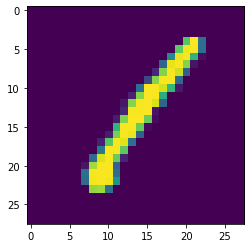

In [3]:
img = np.array(train.iloc[0]).reshape(28, 28)
_ = plt.imshow(img)

In [4]:
class Conv2D(Node):
    def __init__(self, nodes, weights, bias, stride=1, padding=False):
        self.stride = stride
        self.padding = padding
        self.bias = True if bias else False
        Node.__init__(self, [nodes, weights, bias] if bias else [nodes, weights])

    def conv_(self, n_h, n_w, img, filter_, s=1):
        k1, k2 = filter_.shape[0], filter_.shape[1]
        res = np.zeros((n_h, n_w))
        for i in range(n_h):
            for j in range(n_w):
                res[i][j] = np.sum(img[i*s:i*s+k1,j*s:j*s+k2]*filter_)
        return res
        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        if self.bias:
            bias = self.inputs[2].value
        ks = weights.shape[0]  # kernel size

        s = self.stride
        if self.padding:
            inputs = np.pad(inputs, (ks//2, ks//2), 'constant')
        assert (inputs.shape[0]-ks)%s == 0
        assert (inputs.shape[1]-ks)%s == 0
        assert s < ks

        new_h = (inputs.shape[0]-ks)//s+1
        new_w = (inputs.shape[1]-ks)//s+1

        self.value = self.conv_(new_h, new_w, inputs, weights, s=s) + (bias if self.bias else 0)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        s = self.stride
        k = self.inputs[1].value.shape[0]
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_cost = n.gradients[self]
            
            if s > 1:
                tmp = np.insert(grad_cost.reshape(-1,1), 1, [[0]]*(s-1), axis=1)
                tmp = tmp.reshape(grad_cost.shape[0], -1)[:,:-(s-1)]
                tmp = np.insert(tmp, np.repeat(range(1,len(tmp)), (s-1)), [0]*tmp.shape[1], axis=0)
                inser_grad = np.pad(tmp, (k-1, k-1), 'constant')
            else:
                inser_grad = np.pad(grad_cost, (k-1, k-1), 'constant')
            
            rotated_w = np.rot90(self.inputs[1].value, 2)
            
            n_h = self.gradients[self.inputs[0]].shape[0]
            n_w = self.gradients[self.inputs[0]].shape[1]
            self.gradients[self.inputs[0]] += self.conv_(n_h, n_w, inser_grad, rotated_w, s=1)

            self.gradients[self.inputs[1]] += np.rot90(self.conv_(k, k, inser_grad, X, s=1), 2)
            
            if self.bias:
                self.gradients[self.inputs[2]] += np.sum(grad_cost)

In [5]:
class AvePooling(Node):
    def __init__(self, nodes, k=3):
        self.k = k
        Node.__init__(self, [nodes])

    def conv_(self, n_h, n_w, img, filter_, s=1):
        k = self.k
        res = np.zeros((n_h, n_w))
        for i in range(n_h):
            for j in range(n_w):
                res[i][j] = np.sum(img[i*s:i*s+k,j*s:j*s+k]*filter_)
        return res
        
    def forward(self):
        inputs = self.inputs[0].value
        k = self.k
        
        assert inputs.shape[0]%k == 0
        assert inputs.shape[1]%k == 0
        assert k > 1

        filter_ = np.ones((k, k))/(k*k)
        new_h = inputs.shape[0]//k
        new_w = inputs.shape[1]//k

        self.value = self.conv_(new_h, new_w, inputs, filter_, s=k)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        s = k = self.k
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_cost = n.gradients[self]

            tmp = np.insert(grad_cost.reshape(-1,1), 1, [[0]]*(s-1), axis=1)
            tmp = tmp.reshape(grad_cost.shape[0], -1)[:,:-(s-1)]
            tmp = np.insert(tmp, np.repeat(range(1,len(tmp)), (s-1)), [0]*tmp.shape[1], axis=0)
            inser_grad = np.pad(tmp, (k-1, k-1), 'constant')
            
            w = np.ones((k, k))/(k*k)
            
            n_h = self.gradients[self.inputs[0]].shape[0]
            n_w = self.gradients[self.inputs[0]].shape[1]
            self.gradients[self.inputs[0]] += self.conv_(n_h, n_w, inser_grad, w, s=1)

In [6]:
class Flatten(Node):
    def __init__(self, nodes):
        Node.__init__(self, [nodes])
        
    def forward(self):
        inputs = self.inputs[0].value
        self.value = inputs.flatten().reshape(1,-1)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] += grad_cost.reshape(X.shape[0],X.shape[1])

In [7]:
W1 = np.random.randn(5, 5)
b1 = np.random.randn(1)

W2 = np.random.randn(3, 3)
b2 = np.random.randn(1)

W3 = np.random.randn(49, 20)
b3 = np.random.randn(20)

W4 = np.random.randn(20, 10)

x_node, y_node = Placeholder(), Placeholder()

W1_node = Placeholder()
b1_node = Placeholder()

W2_node = Placeholder()
b2_node = Placeholder()

W3_node = Placeholder()
b3_node = Placeholder()

W4_node = Placeholder()

conv1 = Conv2D(x_node, W1_node, b1_node, stride=1, padding=True)
ave1 = AvePooling(conv1, k=2)
conv2 = Conv2D(ave1, W2_node, b2_node, stride=1, padding=True)
ave2 = AvePooling(conv2, k=2)
flat = Flatten(ave2)
l1 = Linear(flat, W3_node, b3_node)
tanh = Sigmoid(l1)
l2 = Linear(tanh, W4_node, None)
mse = MSE(y_node, l2)

In [8]:
feed_dict = {
    x_node: img,
    y_node: np.array([0,1,0,0,0,0,0,0,0,0]),
        
    W1_node: W1,
    b1_node: b1,

    W2_node: W2,
    b2_node: b2,
    
    W3_node: W3,
    b3_node: b3,
    
    W4_node: W4
}

graph = feed_dict_2_graph(feed_dict)    # network graph
sorted_graph = topology(graph)          # sorted graph
trainables = [W1_node, b1_node, W2_node, b2_node, W3_node, b3_node, W4_node]

In [9]:
optimizer = 'Adam'
lr=1e-2
epochs=200

# only used for Adam
it = 0

for i in range(1, epochs+1):
    it += 1
    # Step 4.1: sample a batch of examples and Reset value
    x_node.value = np.array(train.iloc[i]).reshape(28, 28)
    y_node.value = np.eye(10)[train_label[i]].reshape(1,-1)

    # Step 4.2: forward
    for n in sorted_graph:
        n.forward()

    # Step 4.3: backward
    for n in sorted_graph[::-1]:
        n.backward()

    # Step 4.4: optimization
    for t in trainables:
        t.optimize(optimizer=optimizer, lr=lr, it=it)

    # Step 5: update current loss
    loss = sorted_graph[-1].value

    if (i+1) % 10 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i+1, loss))

Epoch: 10, Loss: 3.0578
Epoch: 20, Loss: 3.4466
Epoch: 30, Loss: 4.2445
Epoch: 40, Loss: 5.3505
Epoch: 50, Loss: 2.5725
Epoch: 60, Loss: 2.3173
Epoch: 70, Loss: 1.1733
Epoch: 80, Loss: 1.6929
Epoch: 90, Loss: 4.6165
Epoch: 100, Loss: 1.3390
Epoch: 110, Loss: 1.1842
Epoch: 120, Loss: 3.2967
Epoch: 130, Loss: 4.0610
Epoch: 140, Loss: 0.6201
Epoch: 150, Loss: 0.2854
Epoch: 160, Loss: 0.8532
Epoch: 170, Loss: 2.9716
Epoch: 180, Loss: 1.5569
Epoch: 190, Loss: 0.3955
Epoch: 200, Loss: 0.7818


In [10]:
for i in range(10):
    x_node.value = np.array(train.iloc[i]).reshape(28, 28)
    for n in sorted_graph[:-1]:
        n.forward()
    print(f"pred: {np.argmax(sorted_graph[-2].value)}, real: {train_label[i]}")

pred: 6, real: 1
pred: 1, real: 0
pred: 0, real: 1
pred: 7, real: 4
pred: 8, real: 0
pred: 3, real: 0
pred: 1, real: 7
pred: 0, real: 3
pred: 5, real: 5
pred: 1, real: 3


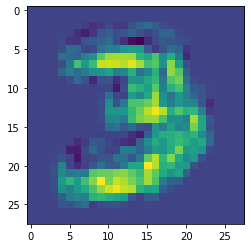

In [11]:
_ = plt.imshow(conv1.value)

In [12]:
def conv(img, kernel_size=3, stride=1, padding=False):
    s = stride
    if padding:
        ud = np.zeros((kernel_size//2, img.shape[1]), dtype=np.int32)
        img = np.vstack((ud, img, ud))
        lr = np.zeros((img.shape[0], kernel_size//2), dtype=np.int32)
        img = np.hstack((lr, img, lr))
    assert (img.shape[0]-kernel_size)%s == 0
    assert (img.shape[1]-kernel_size)%s == 0
    assert s < kernel_size
    
    filter_ = np.ones((kernel_size, kernel_size))
    new_h = (img.shape[0]-kernel_size)//s+1
    new_w = (img.shape[1]-kernel_size)//s+1
    
    nex_img = np.zeros((new_h, new_w))
    for i in range(new_h):
        for j in range(new_w):
            nex_img[i][j] = np.sum(img[i*s:i*s+kernel_size,j*s:j*s+kernel_size]*filter_)
    return nex_img

def pooling(img, size):
    assert (img.shape[0]%size == 0)
    assert (img.shape[1]%size == 0)
    
    new_size = img.shape[0]//size
    nex_img = np.zeros((new_size, new_size))
    
    for i in range(new_size):
        for j in range(new_size):
            nex_img[i][j] = np.sum(img[i*size:(i+1)*size,j*size:(j+1)*size])/(size**2)
    return nex_img

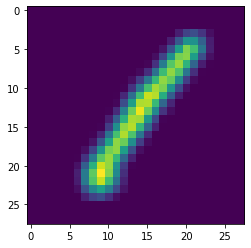

In [13]:
res = conv(img, kernel_size=3, stride=1, padding=True)
_ = plt.imshow(res)

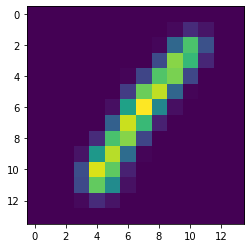

In [14]:
pooled = pooling(res, size=2)
_ = plt.imshow(pooled)